In [1]:
                                            ## IMPORT ERFORDERLICHER BIBLIOTHEKEN UND FUNKTIONEN ##

'''Datenverarbeitung & Lineare Algebra'''
import numpy as np       # NumPy für numerische Operationen
import pandas as pd      # Pandas für Datenmanipulation und -analyse
from tqdm import tqdm    # tqdm für eine hübsche Fortschrittsleiste

import os                # os für Betriebssystemspezifische Funktionen
import random            # Random für zufällige Operationen

'''Datenanalyse Datenmanipulation und Modellerstellung''' ## Import der Keras-Layer für das neuronale Netzwerk
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Reshape
import tensorflow as tf         ## TensorFlow für das Deep Learning Framework
from keras.models import Model  ## Import des Modell-Objekts aus Keras
from tensorflow.keras.initializers import glorot_uniform  ## Import des Initialisierers für Gewichte

'''Visualisierung'''
import matplotlib.pyplot as plt # Matplotlib für grundlegende Diagramme

'''Bildverarbeitungsfunktionen'''
from skimage.color import rgb2gray as rtg  # Import von Funktionen für die Farbkonvertierung
from skimage.io import imread, imshow      # Import von Funktionen für das Lesen und Anzeigen von Bildern
from skimage.transform import resize       # Import von Funktionen für die Bildskalierung
from skimage.morphology import label       # Import von Funktionen für die Objekterkennung
from PIL import Image                      # Import von Funktionen für die Bildbearbeitung mit der PIL-Bibliothek


In [2]:
# Die Maximale-Pixel-Grenze wird deaktiviert
Image.MAX_IMAGE_PIXELS = None

# Das Bild wird geöffnet
IMG = Image.open(r"D:\Muttsee Data\Muttsee.png")

# Die Größe des Bildes wird angezeigt
IMG.size

(20000, 10000)

# Untersuchungsgebiet: Muttsee-Staumauer und Solaranlage
''' Die Staumauer des Muttsees liegt auf 2’500 Metern über Meer und wurde 2017 mit einer Betonmauer erneuert. 
Seit 2022 ist die Anlage mit einer 10'000 m2 grossen Solaranlage voll in Betrieb. Dank der Höhenlage und den tiefen Temperaturen produzieren 
die Solarpanels zu jeder Jahreszeit besonders effizient Strom. Dieses alpine Solar-Grosskraftwerk in den Glarner Alpen leistet einen wichtigen 
Beitrag zur Nachhaltigkeit: Es deckt einen Teil des höheren Strombedarfs im Winter und kann so Strom für über 600 Haushalte produzieren. 
Quelle (Bundesamt für Landestopografie swisstopo) '''

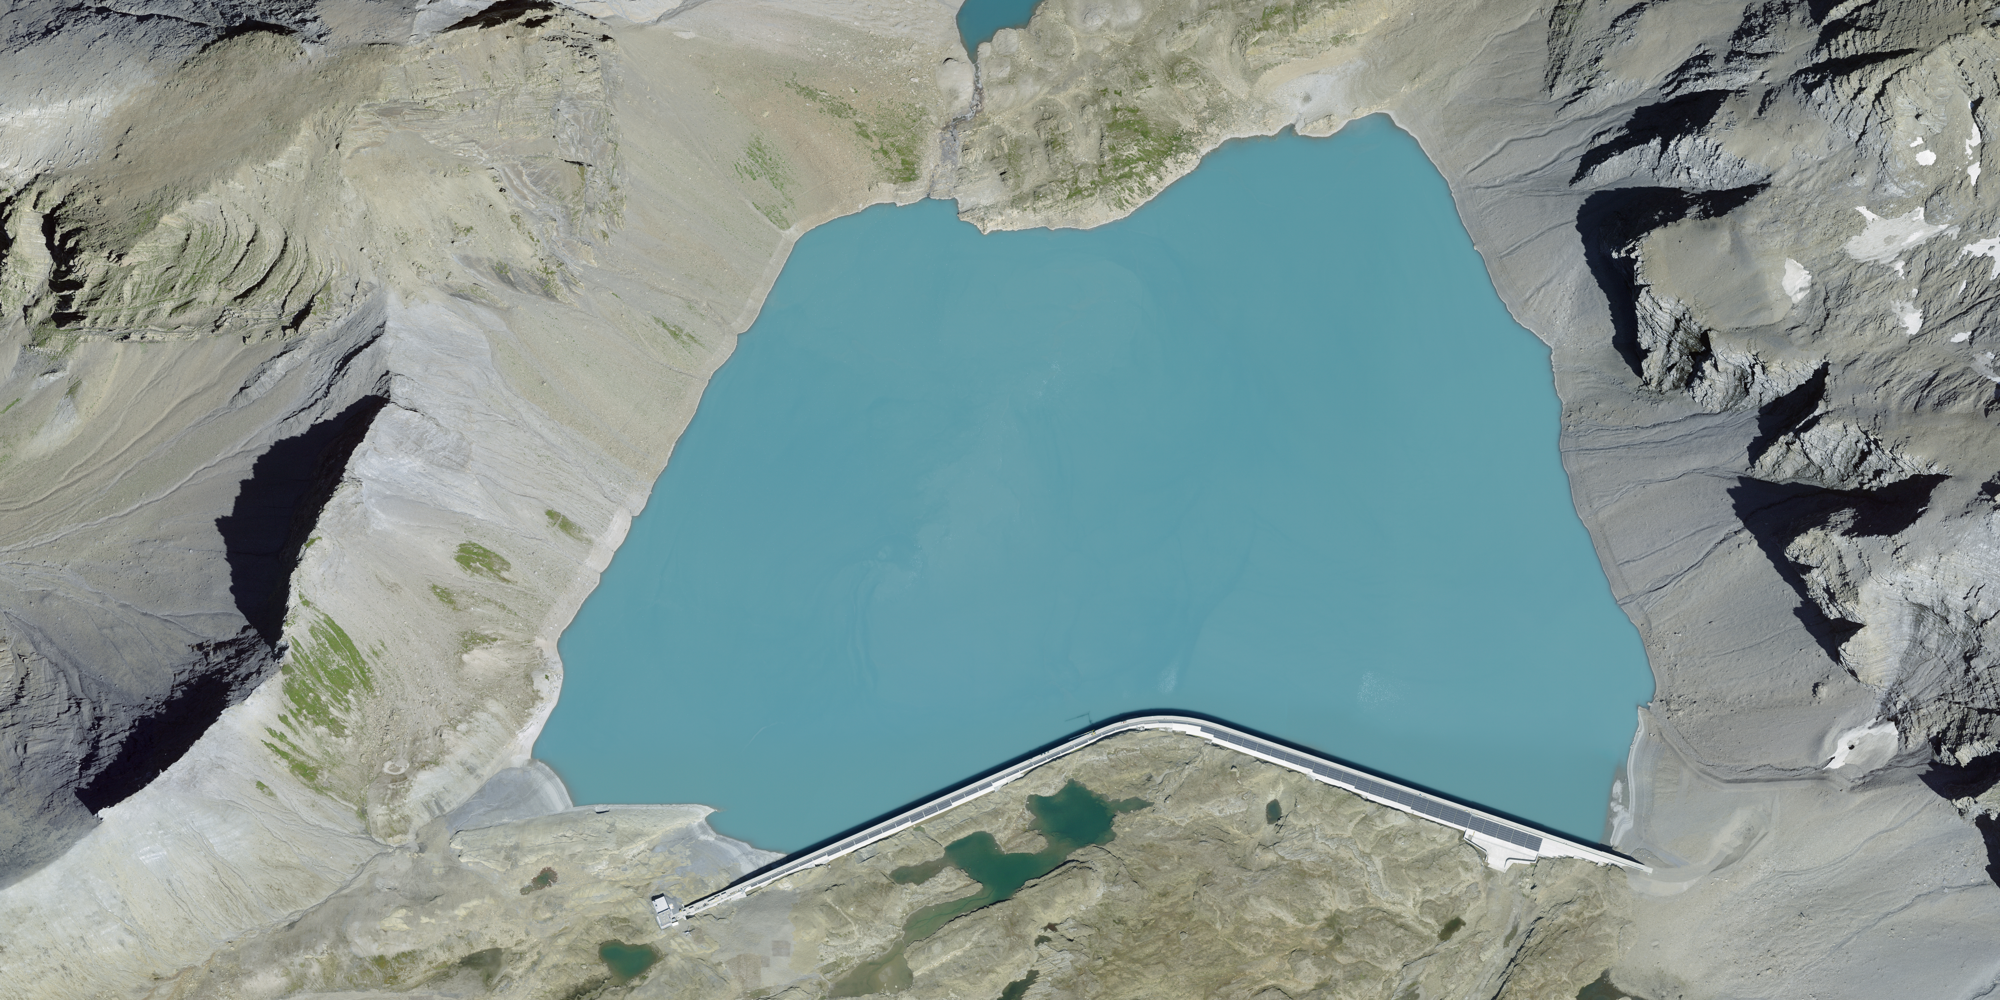

In [4]:
# Das Bild wird auf ein Zehntel seiner Größe skaliert und angezeigt
img_small = IMG.resize((round(IMG.size[0]/10), round(IMG.size[1]/10)))
img_small

In [5]:
# Hier werden die Verzeichnisse für Trainingsbilder und Trainingslabel definiert.
imagesPath = r"D:\Muttsee Data\Image"  # Verzeichnis für Trainingsbilder
masksPath = r"D:\Muttsee Data\Mask"  # Verzeichnis für Trainingslabel 

In [6]:
# Anzahl der Dateien im Bilder- und Maskenverzeichnis
len(os.listdir(imagesPath)), len(os.listdir(masksPath))

(184, 184)

In [9]:
# Extrahiere Dateinamen im Format 0.jpg
images_ids = next(os.walk(imagesPath))[2]
masks_ids = next(os.walk(masksPath))[2]

In [10]:
# Gesamtzahl der Bilder und Masken wird ausgegeben
print(f"Total images: {len(images_ids)}\nTotal masks: {len(masks_ids)}")

Total images: 184
Total masks: 184


In [11]:
# Erstellen eines leeren Arrays mit der Länge von image_ids, d. h. 290, 256, 256, 3
X = np.zeros((len(images_ids), 256, 256, 3), dtype=np.uint8)
Y = np.zeros((len(masks_ids), 256, 256, 1), dtype=np.bool_)

In [12]:
# Bilder werden auf 256x256 skaliert und dann der oben genannten Matrix hinzugefügt

print("Resizing training images and masks")
for n, id_ in tqdm(enumerate(images_ids), total=len(images_ids)): # Durchlaufe alle Bild-IDs
    path = imagesPath + "/" + id_ # Pfad zum aktuellen Bild
    img = Image.open(path)
    img = np.array(img) # Das Bild wird in ein NumPy-Array konvertiert
    img = resize(img, (256, 256, 3), mode="constant", preserve_range=True)
    X[n] = img
    mask = np.zeros((256, 256, 1), dtype=np.bool_)
    mask = imread(masksPath + "/" + id_.split(".")[0] + ".tif")
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    Y[n] = mask # Hier wird die skalierte Maske zur Matrix Y hinzugefügt

Resizing training images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 184/184 [00:04<00:00, 37.70it/s]


In [13]:
# Form der Daten wird ausgegeben
print(f"X.shape: {X.shape}\nY.shape: {Y.shape}")

X.shape: (184, 256, 256, 3)
Y.shape: (184, 256, 256, 1)


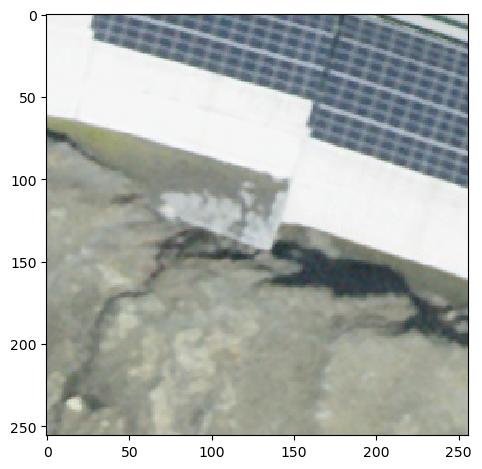

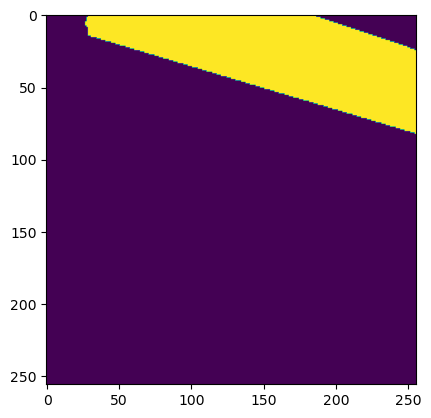

In [15]:
# Zufällige Bilder und ihre Masken werden geplottet
image_x = random.randint(0, len(images_ids))
imshow(X[image_x])
plt.show()
plt.imshow(np.squeeze(Y[image_x]))

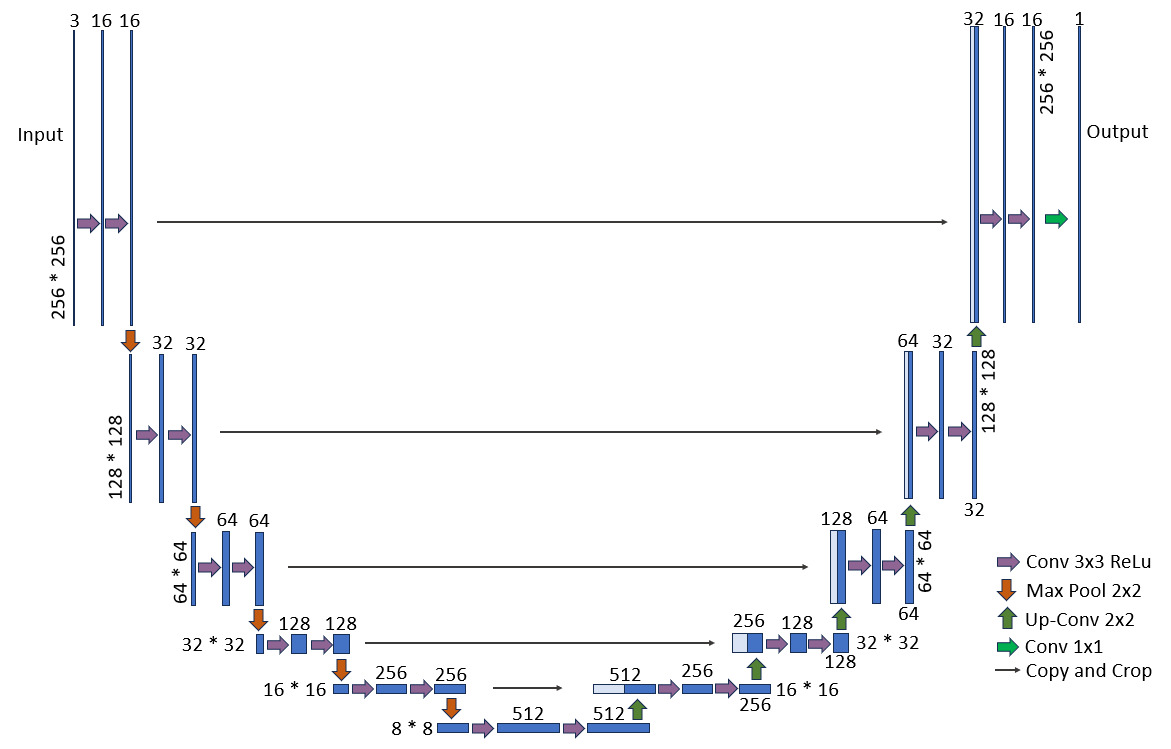

In [15]:
## U-Net Architektur
UNet = Image.open(r"D:\Muttsee Data\Unsere U-Net-Architektur.jpeg")
UNet

In [21]:
# U-Net Architektur wird erstellt

# Eingangsbild
input = tf.keras.layers.Input((256, 256, 3))

# Konfiguration zur Reduzierung des Bildes
s = tf.keras.layers.Lambda(lambda x: x / 256)(input)

# block 1
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# block 2
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# block 3
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3  = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# block 4
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

# block 5
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

# block 6
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# block 7 - back 1
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# block 8 - back 2
u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# block 9 - back 3
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# block 10 - back 4
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

# block 11 - back 5
u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1])
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)
# U-Net Modell wird erstellt
modelUNet = tf.keras.Model(inputs=input, outputs=outputs, name='U-NET')
# Modell wird kompiliert
modelUNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
modelUNet.summary()

Model: "U-NET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv2d_34 (Conv2D)          (None, 256, 256, 16)         448       ['lambda_1[0][0]']            
                                                                                                  
 conv2d_35 (Conv2D)          (None, 256, 256, 16)         2320      ['conv2d_34[0][0]']           
                                                                                              

In [23]:
#Hier werden Callbacks für das Training des Modells definiert und das Modell wird mit den Trainingsdaten (X) 
#und den zugehörigen Labels (Y) für 20 Epochen trainiert.

callbacks=[
#     tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs")]

# Modell wird trainiert
results = modelUNet.fit(X, Y, validation_split=0.1, batch_size=16, epochs=20, callbacks=callbacks)

Epoch 1/20
11/11 [==============================] - 39s 3s/step - loss: 0.3697 - accuracy: 0.8737 - val_loss: 0.1809 - val_accuracy: 0.9689
Epoch 2/20
11/11 [==============================] - 31s 3s/step - loss: 0.2691 - accuracy: 0.9192 - val_loss: 0.1499 - val_accuracy: 0.9689
Epoch 3/20
11/11 [==============================] - 31s 3s/step - loss: 0.2260 - accuracy: 0.9192 - val_loss: 0.0985 - val_accuracy: 0.9689
Epoch 4/20
11/11 [==============================] - 31s 3s/step - loss: 0.1743 - accuracy: 0.9192 - val_loss: 0.0737 - val_accuracy: 0.9689
Epoch 5/20
11/11 [==============================] - 31s 3s/step - loss: 0.1595 - accuracy: 0.9192 - val_loss: 0.0682 - val_accuracy: 0.9689
Epoch 6/20
11/11 [==============================] - 30s 3s/step - loss: 0.1488 - accuracy: 0.9192 - val_loss: 0.0693 - val_accuracy: 0.9689
Epoch 7/20
11/11 [==============================] - 30s 3s/step - loss: 0.1500 - accuracy: 0.9192 - val_loss: 0.0611 - val_accuracy: 0.9689
Epoch 8/20
11/11 [==

In [26]:
# Function to plot the training curve with the best model indication

def plot_training(hist):
    '''
        Diese Funktion nimmt das Trainingsmodell entgegen und plottet den Verlauf von Genauigkeit (Accuracy) und Verlusten (Loss) während des Trainings. 
        Sie markiert auch die beste Epoche in beiden Diagrammen.   
    '''

     # Die benötigte Variablen definieren
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Trainingsverlauf plotten
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

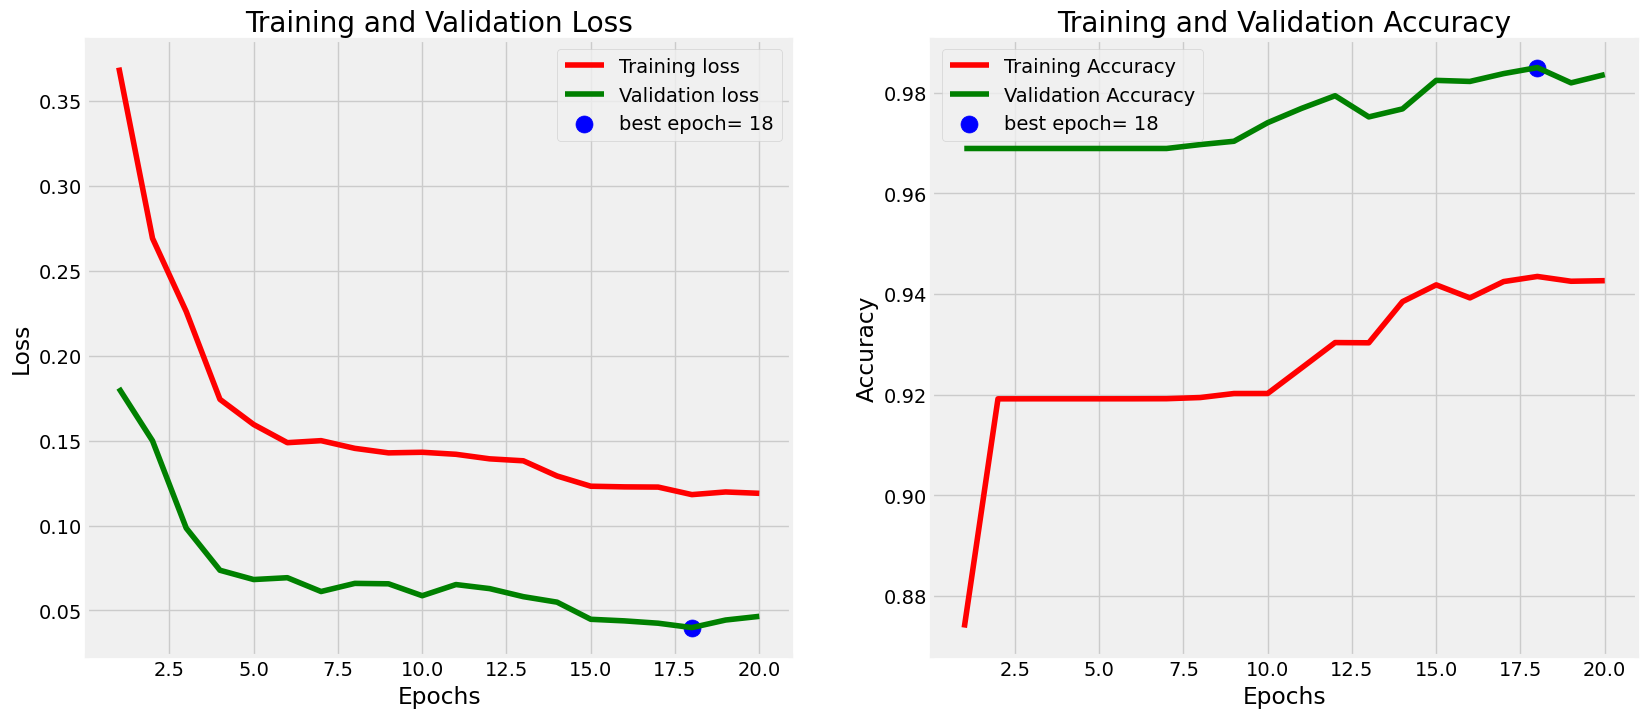

In [27]:
plot_training(results)

In [ ]:
# Das Modell wird evaluiert
modelUNet.evaluate(X, Y)

<Figure size 3000x3000 with 0 Axes>

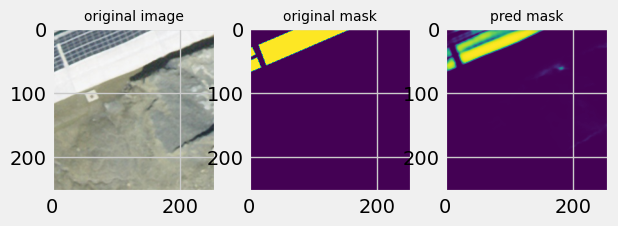

In [73]:
# Zufälliges Bild, Maske und vorhergesagte Maske werden angezeigt

plt.figure(figsize=(30,30))

ind = random.randint(0, len(X))
img = X[ind]
predMask = modelUNet.predict(np.expand_dims(img, axis=0), verbose=0)
fig = plt.figure()
ax1 = fig.add_subplot(2, 3, 1)
ax1.set_title("original image", fontdict = {'fontsize' : 10})
ax1.imshow(X[ind])
ax2 = fig.add_subplot(2, 3, 2)
ax2.set_title("original mask", fontdict = {'fontsize' : 10})
ax2.imshow(np.squeeze(Y[ind]))
ax3 = fig.add_subplot(2, 3, 3)
ax3.set_title("pred mask", fontdict = {'fontsize' : 10})
ax3.imshow(np.squeeze(predMask))

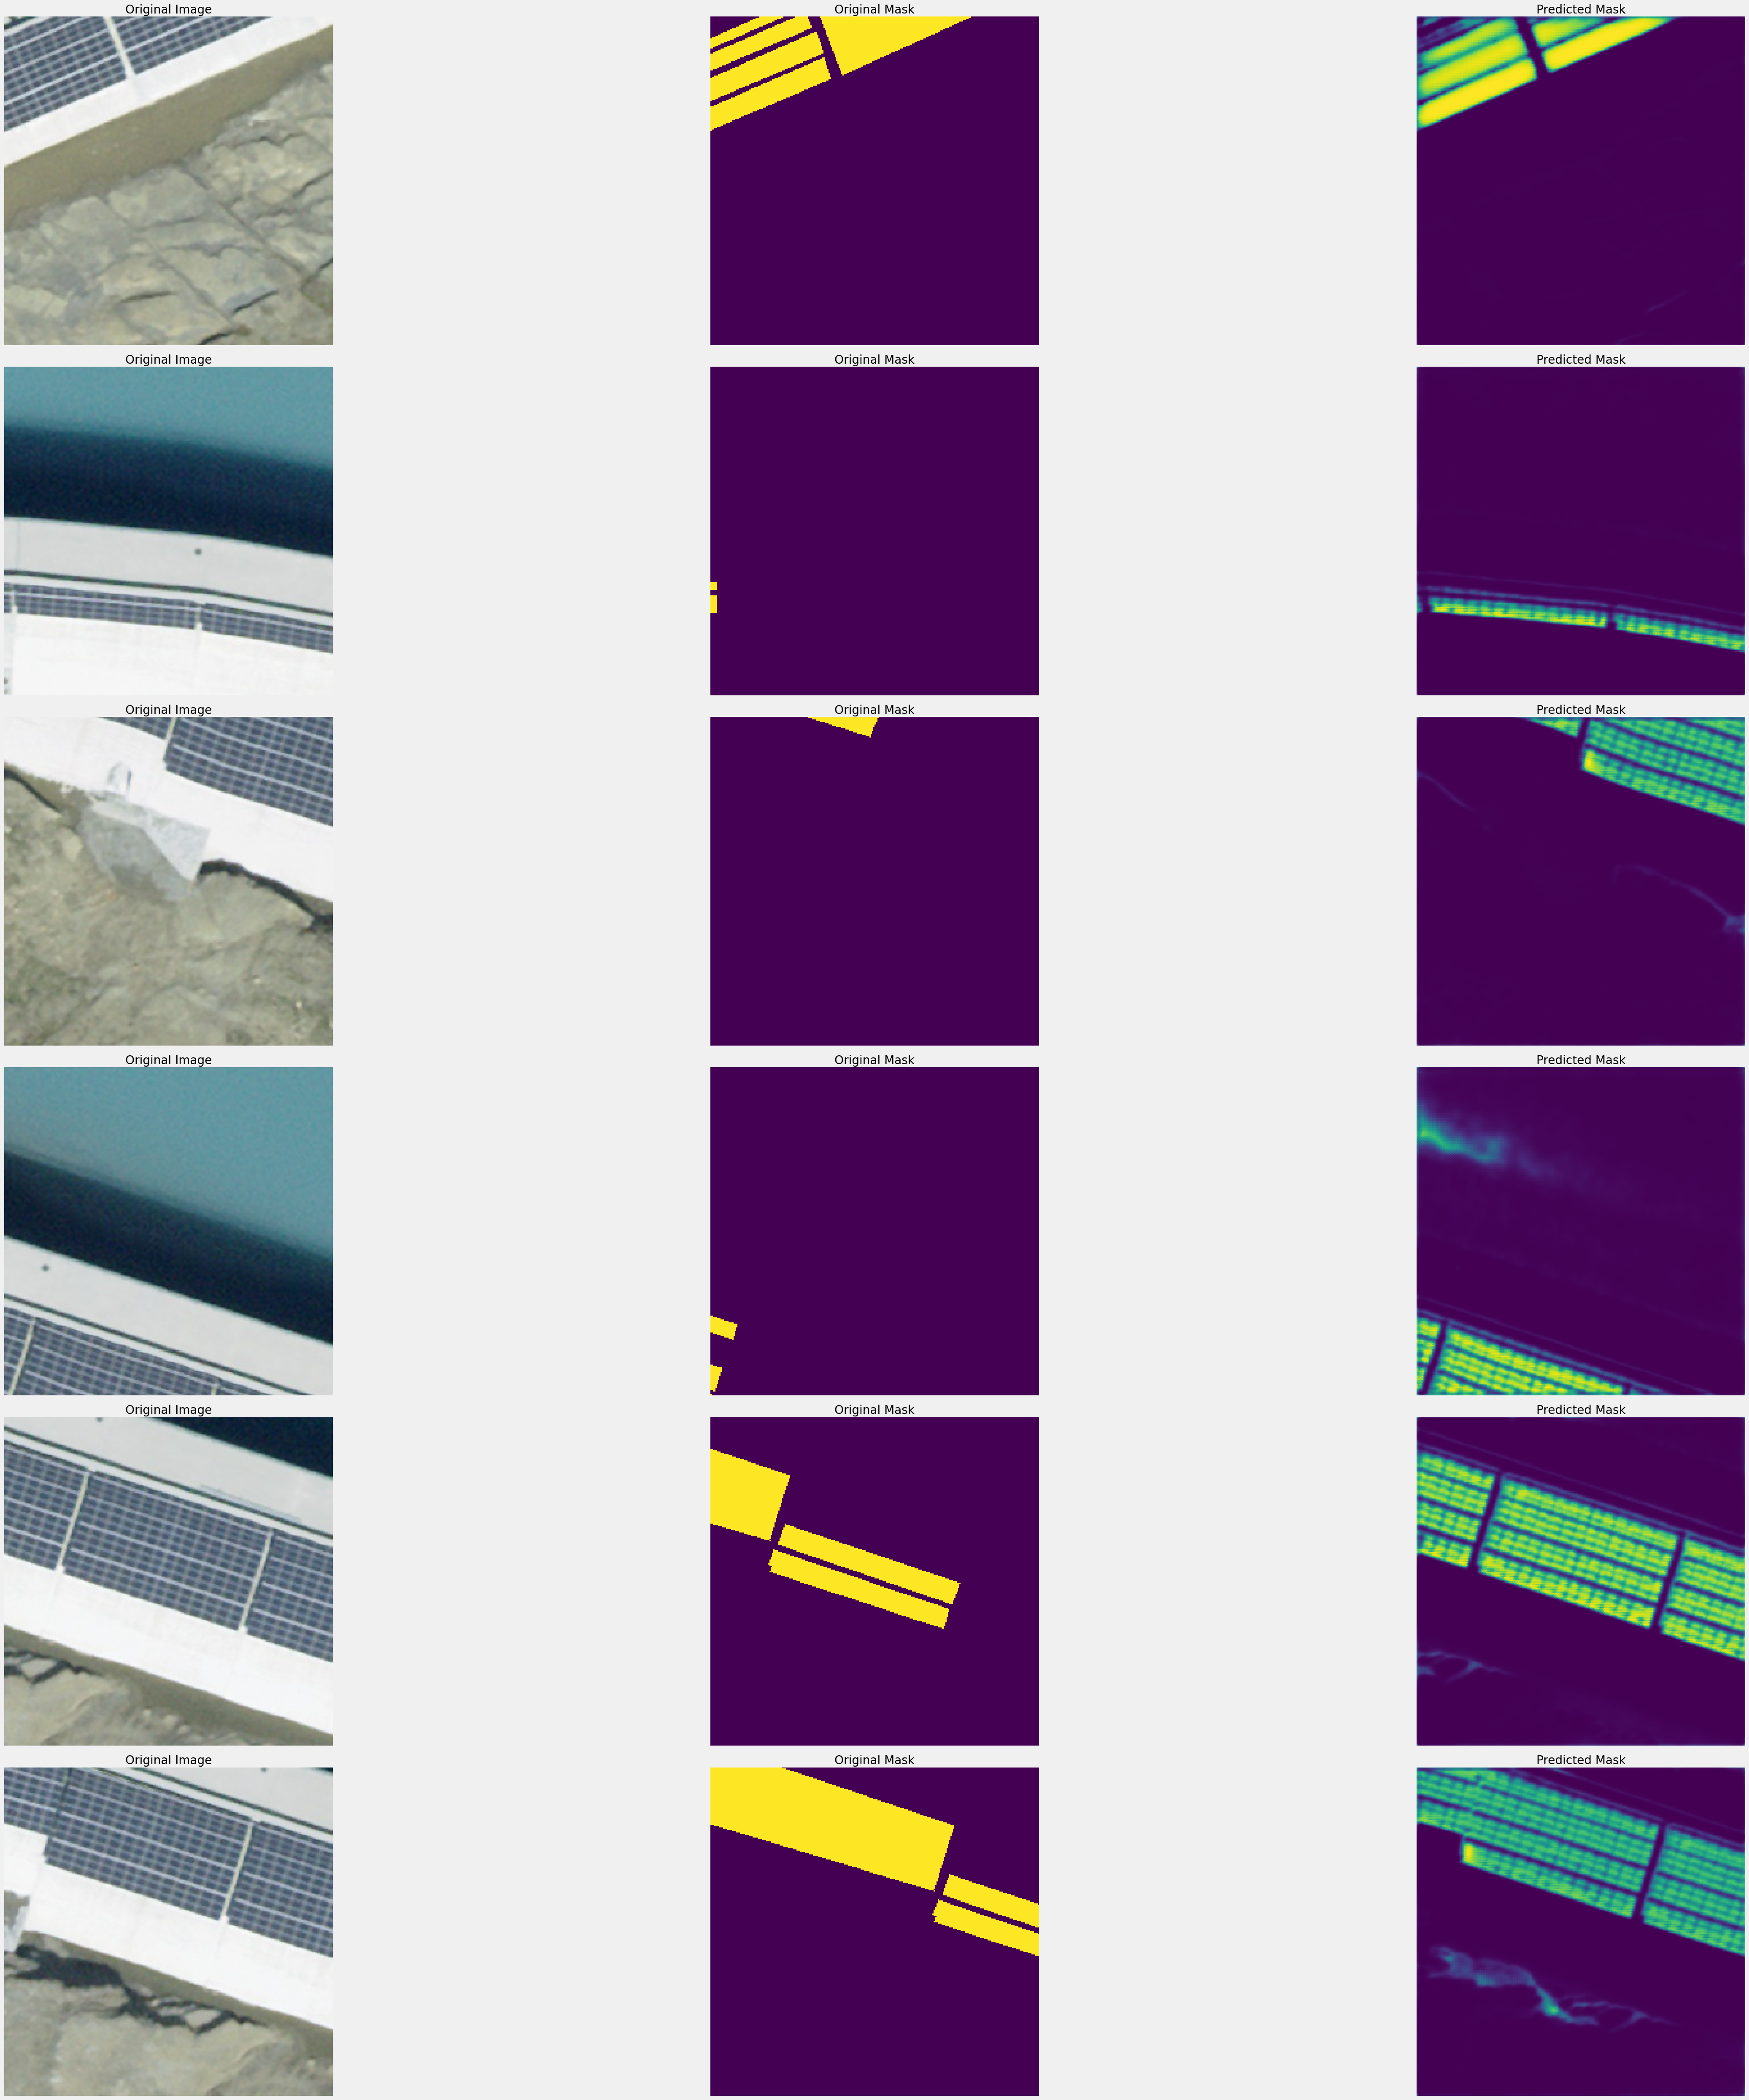

In [74]:
# Und hier wird nochmal ein zufälliges Bild aus den Testdaten ausgewählt, die entsprechende originale Maske und die vom Modell vorhergesagte Maske angezeigt.
plt.figure(figsize=(60, 50))  # Größe des Diagramms anpassen


for i in range(6):
    ind = random.randint(0, len(X) - 1)  # Wir stellen sicher, dass der Index im Bereich liegt
    img = X[ind]
    predMask = modelUNet.predict(np.expand_dims(img, axis=0), verbose=0)
    
    plt.subplot(6, 3, i * 3 + 1)
    plt.imshow(X[ind])
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(6, 3, i * 3 + 2)
    plt.imshow(np.squeeze(Y[ind]))
    plt.title("Original Mask")
    plt.axis('off')

    plt.subplot(6, 3, i * 3 + 3)
    plt.imshow(np.squeeze(predMask))
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Am Ende haben wir unser Modell im HDF5-Format (.h5) gespeichert.
modelUNet.save('SolarPanel.h5')